# Notebook 7: Investigating the MCMC chains of fitted models

In notebook 6 we covered using an ensemble of parameter draws from their posterior distribution, aka the MCMC chain, to make forecasts. In this notebook, we briefly look at visualising the chains themselves and look at some simple chain diagnostics. 

The `KenyaSerology.inferparameters!` function adds a MCMC chain object to the `CoVAreaModel` object containing all the data for the Kenyan county. Rather than reinvent the wheel, the MCMC chain is represented as a `Chains` object, which is part of the [Turing.jl](https://github.com/TuringLang/Turing.jl) ecosystem. Therefore, any tutorial for Turing on visualing and diagnostics of MCMC convergence applies to us too. Below is a flavour.

As before, we first access a model fit we did earlier.

In [29]:
cd(joinpath(homedir(),"GitHub/KenyaSerology/")) #Sets the working directory to the /KenyaSerology directory
push!(LOAD_PATH, joinpath(homedir(),"GitHub/KenyaSerology/src")) #Adds the source code directory for KenyaSerology to the LOAD_PATH global variable

using JLD2,StatsPlots,Dates,DataFrames
using Distributions,TransformVariables,Parameters #These packages define some useful methods
using DynamicHMC.Diagnostics,MCMCChains,MCMCDiagnostics

import KenyaSerology

@load("modelfits/nairobi_model_Peff_shortsi_var_testing.jld2")#This is fitted model for Nairobi we used in the paper
nairobi_inference_model = nairobi_model_Peff_shortsi_var_testing; #For consistency in naming with notebook 5


┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1278


Now we can access the `Chains` object that represents the draws from the MCMC inference process saved with the data for the Kenyan county (in this case Nairobi). Just calling the object gives summary statistics of the posterior distributions of the parameters.

In [22]:
chn = nairobi_inference_model.MCMC_results.chain

Chains MCMC chain (10000×6×1 Array{Float64,3}):

Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = R, E₀, I₀, α, p_test, P_eff

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat  
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64  
                                                                             
           R    2.0052    0.0443     0.0004    0.0005     64.2171    1.0000  
          E₀   40.4016   18.0540     0.1805    0.2356   9981.8231    1.0000  
          I₀    2.5629    1.7691     0.0177    0.0239   8097.2410    0.9999  
           α    0.4792    0.0729     0.0007    0.0011     58.5400    0.9999  
      p_test    0.0003    0.0001     0.0000    0.0000      0.0000    1.0003  
       P_eff    0.7700    0.1473     0.0015    0.0024    111.0310    1.0000  

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5%  
      S

We can use the methods that come with `MCMCChains` and `DynamicHMC.Diagnostics` to have a closer inspection of the chain. Visually, we can look at the sample values and marginal posteriors. 

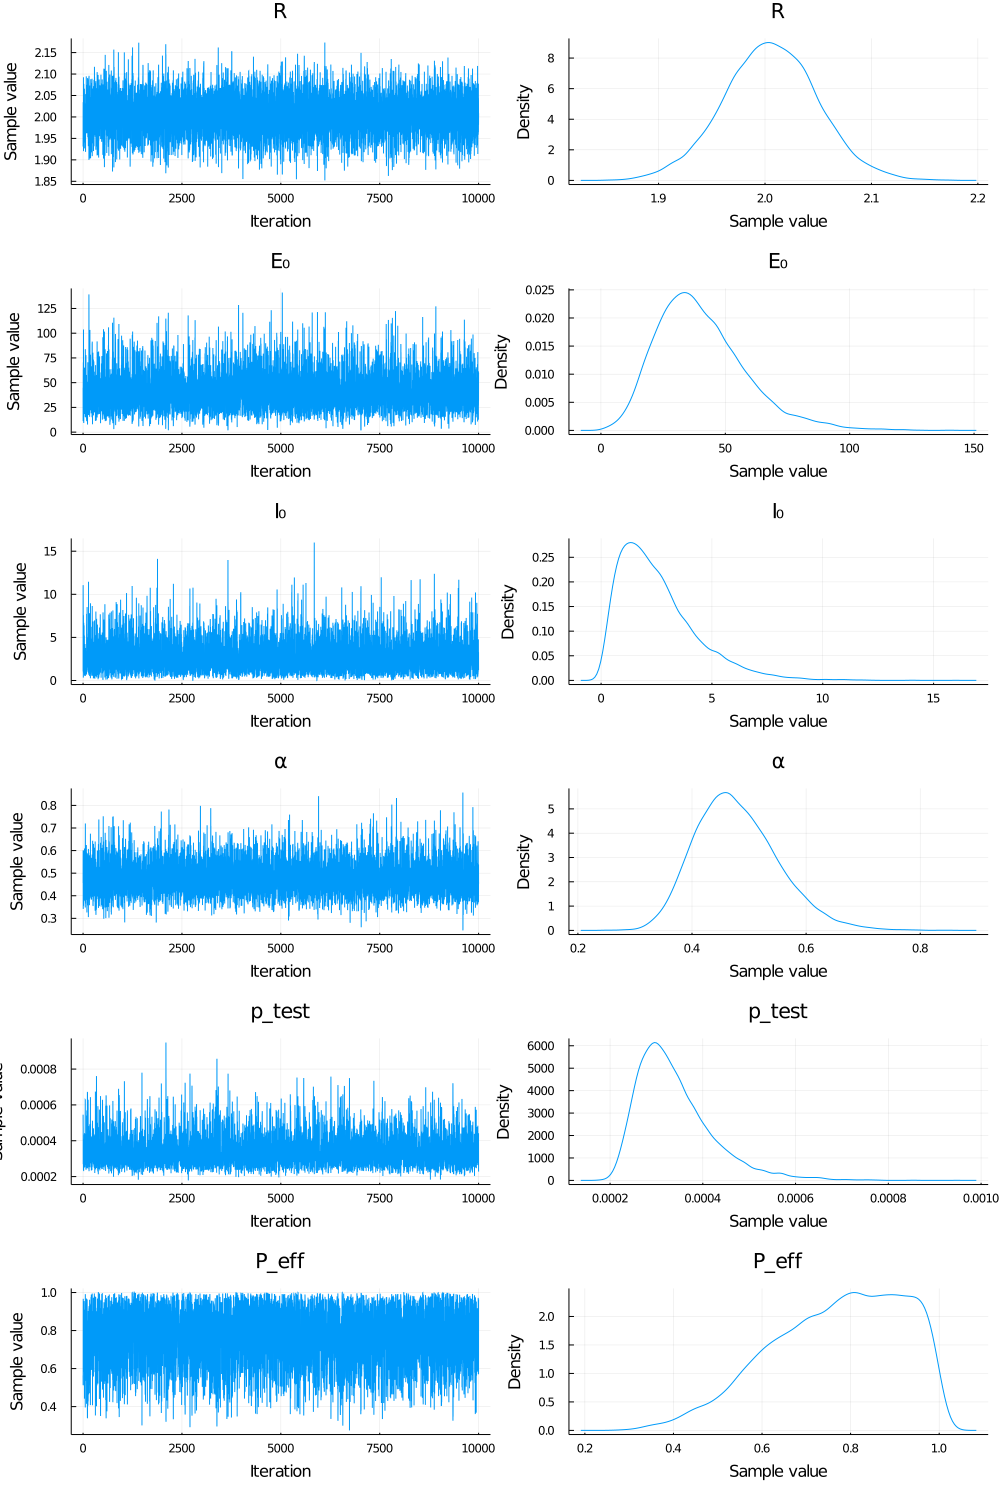

In [23]:
plot(chn; colordim = :chain)

Or a cornerplot for visualing the correlation structure of the posterior distribution.

In [20]:
# plt = corner(chn)
# plot!(plt,size = (700,650))

It is worth taking a moment to think about what the corner plot for the Nairobi fit is telling us. There are two parameter pairs where we observe fairly strong negative correlation between draws:
* $R$ and $E_0$. Higher values of transmissibility are associated with lower numbers of initial exposed.
* $p_{test}$ and $P_{eff}$. Higer values of detection rate are associated with lower values of $P_{eff}$ (i.e. more heterogenous transmission in the population).
This tells us that from the data we have for Nairobi its hard to distinguish between situations where there were a lot of people already infected before control measures and a fundamentally more transmissible disease. And that it is also hard to distinguish between higher detection success and the level of heterogeneity in who is responsible for most transmission.

Convergence diagnostics are available for both the chain (R hat for each parameter is shown as part of the chain summary) and the tree statistics of the HMC+NUTS routine:

In [24]:
summarize_tree_statistics(nairobi_inference_model.MCMC_results.treestatistics)

Hamiltonian Monte Carlo sample of length 10000
  acceptance rate mean: 0.88, 5/25/50/75/95%: 0.63 0.83 0.92 0.97 1.0
  termination: divergence => 0%, max_depth => 0%, turning => 100%
  depth: 0 => 0%, 1 => 0%, 2 => 2%, 3 => 4%, 4 => 17%, 5 => 68%, 6 => 9%

In [35]:
df = DataFrame(Parameter_names = chain.name_map.parameters,
                Effective_sample_size = [effective_sample_size(chain[:,k,1]) for k = 1:size(chain,2)])


,Parameter_names,Effective_sample_size
,Symbol,Float64
1,R,7677.71
2,E₀,5538.59
3,I₀,5542.19
4,α,5250.89
5,p_test,3867.04
6,P_eff,3401.69
